<a href="https://colab.research.google.com/github/superbunny38/2021DeepLearning/blob/main/pytorch/Chap_7_(2)_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN

In [1]:
import os
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.utils as vutils
%matplotlib inline

### 가중치 초기화

In [2]:
def weights_inititialisation(m):
    class_name = m.__class__.__name__
    if class_name.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif class_name.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [3]:
#Size of latnet vector
nz = 100
# Filter size of generator
ngf = 64
# Filter size of discriminator
ndf = 64
# Output image channels
nc = 3

## Generator

In [4]:
class _net_generator(nn.Module):
    def __init__(self):
        super(_net_generator, self).__init__()

        self.main = nn.Sequential(#순차형
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()#네트워크 값들의 범위 제한
        )

    def forward(self, input):
        output = self.main(input)#순차형 모델(sequential)에 전달
        return output


net_generator = _net_generator()
net_generator.apply(weights_inititialisation)#네트워크 객체에서 함수 호출
print(net_generator)

_net_generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
 

## Discriminator

In [5]:
class _net_discriminator(nn.Module):
    def __init__(self):
        super(_net_discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),#판별자의 효율성이 개선
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),#평탄화
            nn.Sigmoid()#sigmoid로 전달
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)


net_discriminator = _net_discriminator()
net_discriminator.apply(weights_inititialisation)#네트워크 객체에서 함수 호출
print(net_discriminator)

_net_discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


### 손실 및 최적화기 정의하기

In [6]:
criterion = nn.BCELoss()
if torch.cuda.is_available():
  criterion.cuda()

In [7]:
lr = 0.0002
beta1 = 0.5
optimizer_discriminator = optim.Adam(net_discriminator.parameters(), lr, betas=(beta1, 0.95))#betas: coefficients used for computing running averages of gradient and its square
optimizer_generator = optim.Adam(net_generator.parameters(), lr, betas=(beta1, 0.95))

### Discriminator loss function

$loss = maximizelog(D(x))+log(1-D(G(z)))$

### Generator loss function
loss = $minimize log(1 – D(G(z)))$

# full training of GAN

In [2]:
img_size = 64
batch_size=64
lr = 0.0002
beta1 = 0.5
niter= 25
outf= 'output'

## Get Data

In [3]:
dataset = datasets.CIFAR10( root = 'data',download=True,
                       transform=transforms.Compose([
                           transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size,
                                         shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data


visualize data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


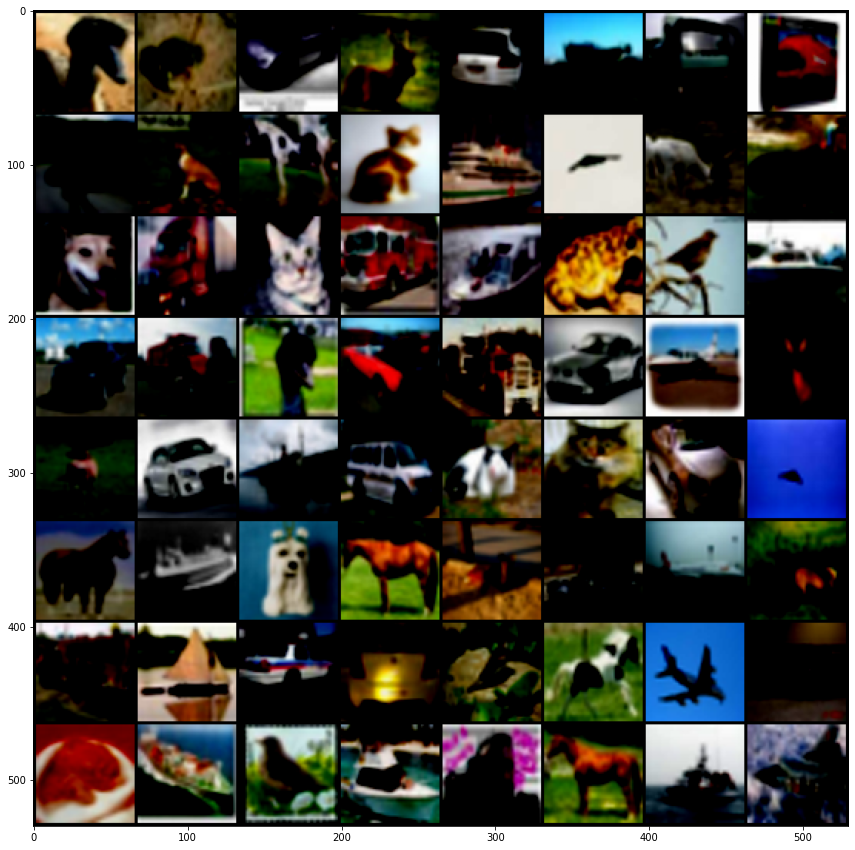

In [4]:
import matplotlib.pyplot as plt
import torchvision
sample = next(iter(dataloader))
# Create a grid 
plt.figure(figsize=(15,15))
images, labels = sample
grid = torchvision.utils.make_grid(tensor=images, nrow=8) # nrow = number of images displayed in each row

# Use grid.permute() to transpose the grid so that the axes meet the specifications required by 
# plt.imshow(), which are [height, width, channels]. PyTorch dimensions are [channels, height, width].
plt.imshow(grid.permute(1,2,0))

In [14]:
#Size of latnet vector
nz = 100
# Filter size of generator
ngf = 64
# Filter size of discriminator
ndf = 64
# Output image channels
nc = 3

## Network Initialization

In [15]:
def weights_inititialisation(m):
    class_name = m.__class__.__name__
    if class_name.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif class_name.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

## Generator

In [16]:
class _net_generator(nn.Module):
    def __init__(self):
        super(_net_generator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output


net_generator = _net_generator()
net_generator.apply(weights_inititialisation)
print(net_generator)

_net_generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
 

## Discriminator

In [17]:
class _net_discriminator(nn.Module):
    def __init__(self):
        super(_net_discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)


net_discriminator = _net_discriminator()
net_discriminator.apply(weights_inititialisation)
print(net_discriminator)

_net_discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Defining loss functions

In [18]:
criterion = nn.BCELoss()

input = torch.FloatTensor(batch_size, 3, img_size, img_size)
noise = torch.FloatTensor(batch_size, nz, 1, 1)
fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1)
label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0

In [19]:
#use gpu
if torch.cuda.is_available():
    net_discriminator.cuda()
    net_generator.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

## Defining optimizer

In [20]:
fixed_noise = Variable(fixed_noise)

optimizer_discriminator = optim.Adam(net_discriminator.parameters(), lr, betas=(beta1, 0.95))
optimizer_generator = optim.Adam(net_generator.parameters(), lr, betas=(beta1, 0.95))

## Training

In [12]:
!mkdir output

In [21]:
generator_loss_list = []
discriminator_loss_list = []
for epoch in range(niter):
    generator_loss = 0
    discriminator_loss = 0
    for i, data in enumerate(dataloader, 0):
        # train with real
        net_discriminator.zero_grad()
        real_cpu, _ = data#real data
        batch_size = real_cpu.size(0)
        if torch.cuda.is_available():
            real_cpu = real_cpu.cuda()
        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)

        #train discriminator with real input
        output = net_discriminator(inputv)
        err_discriminator_real = criterion(output, labelv)
        err_discriminator_real.backward()
        D_x = output.data.mean()

        #train discriminator with fake value
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = net_generator(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = net_discriminator(fake.detach())#generator must not be trained
        err_discriminator_fake = criterion(output, labelv)
        err_discriminator_fake.backward()
        D_G_z1 = output.data.mean()
        err_discriminator = err_discriminator_real + err_discriminator_fake#sum up the errors of discriminator for real and fake inputs
        optimizer_discriminator.step()

        #train generator
        net_generator.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = net_discriminator(fake)
        err_generator = criterion(output, labelv)
        err_generator.backward()
        D_G_z2 = output.data.mean()
        optimizer_generator.step()
        if i%100 == 0 or i == 782:
          print('[%d/%d][%d/%d] Loss_Discriminator: %.4f Loss_Generator: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 err_discriminator.data, err_generator.data, D_x, D_G_z1, D_G_z2))
        generator_loss += err_generator.data
        discriminator_loss = err_discriminator.data

        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = net_generator(fixed_noise)
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)
    generator_loss_list.append(generator_loss / len(dataloader.dataset))
    discriminator_loss_list.append(discriminator_loss / len(dataloader.dataset))  

[0/25][0/782] Loss_Discriminator: 1.9386 Loss_Generator: 6.1648 D(x): 0.5179 D(G(z)): 0.6064 / 0.0028
[0/25][100/782] Loss_Discriminator: 0.4461 Loss_Generator: 6.0714 D(x): 0.8393 D(G(z)): 0.1702 / 0.0043
[0/25][200/782] Loss_Discriminator: 0.4526 Loss_Generator: 2.4231 D(x): 0.7198 D(G(z)): 0.0136 / 0.1525
[0/25][300/782] Loss_Discriminator: 0.6243 Loss_Generator: 6.5465 D(x): 0.7961 D(G(z)): 0.2508 / 0.0030
[0/25][400/782] Loss_Discriminator: 0.5001 Loss_Generator: 2.1889 D(x): 0.8125 D(G(z)): 0.1888 / 0.1426
[0/25][500/782] Loss_Discriminator: 0.2262 Loss_Generator: 3.6616 D(x): 0.9153 D(G(z)): 0.1163 / 0.0379
[0/25][600/782] Loss_Discriminator: 0.7160 Loss_Generator: 4.0053 D(x): 0.5858 D(G(z)): 0.0574 / 0.0559
[0/25][700/782] Loss_Discriminator: 0.3776 Loss_Generator: 3.3231 D(x): 0.7919 D(G(z)): 0.1040 / 0.0524
[1/25][0/782] Loss_Discriminator: 1.2954 Loss_Generator: 7.9837 D(x): 0.9338 D(G(z)): 0.6519 / 0.0007
[1/25][100/782] Loss_Discriminator: 0.5692 Loss_Generator: 3.8907 D(

## 손실 그래프

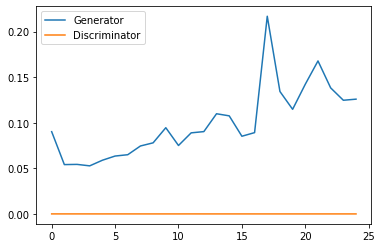

In [22]:
plt.plot(generator_loss_list,label = "Generator")
plt.plot(discriminator_loss_list, label = "Discriminator")
plt.legend()
plt.show()

## 진짜 이미지

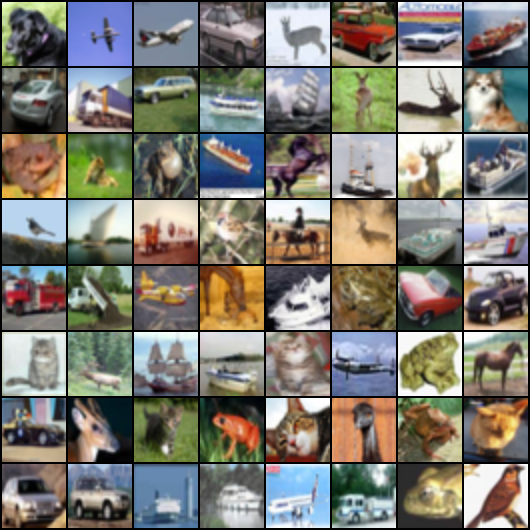

In [23]:
Image.open('output/real_samples.png')

## 생성된 이미지

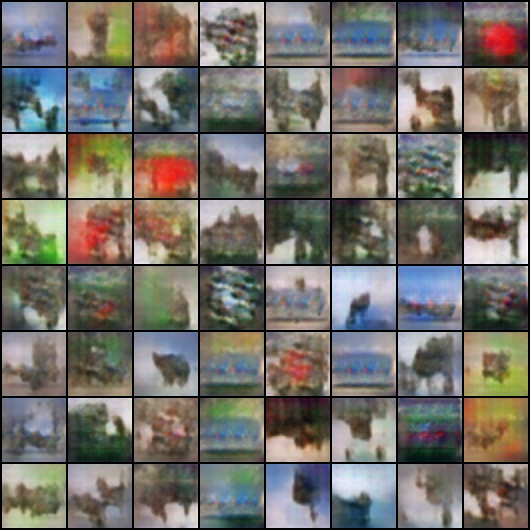

In [24]:
Image.open('output/fake_samples_epoch_024.png')